<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Лемматизация-wordnet" data-toc-modified-id="Лемматизация-wordnet-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Лемматизация wordnet</a></span></li><li><span><a href="#Создание-признаков-tf-idf" data-toc-modified-id="Создание-признаков-tf-idf-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Создание признаков tf-idf</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Метод-опорных-векторов-с-линейным-ядром" data-toc-modified-id="Метод-опорных-векторов-с-линейным-ядром-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Метод опорных векторов с линейным ядром</a></span></li><li><span><a href="#XGBClassifier" data-toc-modified-id="XGBClassifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>XGBClassifier</a></span></li><li><span><a href="#Проверка-лучшей-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-лучшей-модели-на-тестовой-выборке-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Проверка лучшей модели на тестовой выборке</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd

import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import spacy
from sklearn.pipeline import Pipeline



from pymystem3 import Mystem
from sklearn.linear_model import LogisticRegression



from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score, train_test_split



from sklearn.svm import LinearSVC

from sklearn.metrics import f1_score


from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 

import nltk

import torch
import transformers
from tqdm import notebook


from transformers import BertTokenizer,BertConfig, BertModel
RANDOM_STATE = 42

C:\Users\atata\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
data = pd.read_csv("D:/загрузки/toxic_comments.csv")
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


## Подготовка

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


**Непонятно что за столбец `Unnamed: 0` возможно он дублирует индексы, проверим это**

In [4]:
data[list(data.index != data['Unnamed: 0'].values)]

,Unnamed: 0,text,toxic
6080,6084,"""::I'll alos be looking in to see how this is ...",0
6081,6085,"""\n\nThe Ezekiel passage is quoted in the Molo...",0
6082,6086,Thank you for experimenting with Wikipedia. Y...,0
6083,6087,Any complaints with that as the new wording?,0
6084,6088,"""\nI also disagree with the merge as Strength ...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


**Не совпадают. Нужно удалить этот странный столбец непонятного назначения**

In [5]:
data = data.drop('Unnamed: 0', axis = 1)
data.head(3)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0


toxic
0    143106
1     16186
Name: count, dtype: int64

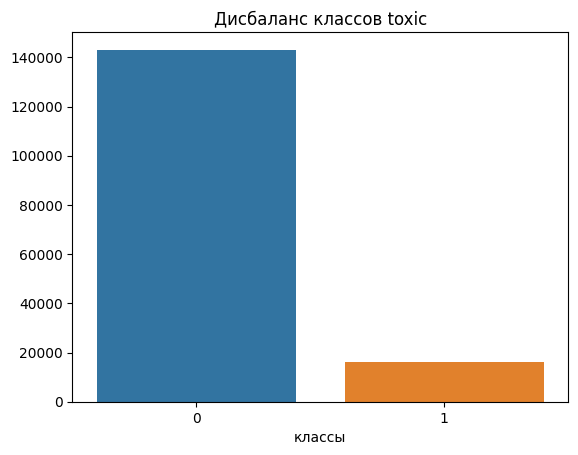

In [6]:
df = data['toxic'].value_counts()

sns.countplot(data = data, x = 'toxic')
plt.title('Дисбаланс классов toxic')
plt.xlabel('классы')
plt.ylabel('')
df

Наблюдается выраженный дисбаланс классов. Тоскичных комментариев гораздо меньше, чем нетоксичных

## Лемматизация spacy (было wordnet)

Проиведем лемматизацию текста твитов методом `wordnet`

In [7]:
data_spacy = pd.read_csv("text_project_spacy", index_col=0)
data_spacy.head()

,toxic,spacy_lemm
0,0,explanation why the edit make under my usernam...
1,0,d aww he match this background colour i m seem...
2,0,hey man i m really not try to edit war it s ju...
3,0,more i can t make any real suggestion on impro...
4,0,you sir be my hero any chance you remember wha...


In [8]:
data.loc[data_spacy[data_spacy['spacy_lemm'].isna()].index.values]

,text,toxic
4475,1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...,0
6289,193.61.111.53 15:00,0
10193,"64.86.141.133""",0
17280,~ \n\n68.193.147.157,0
38743,"88.104.31.21""",0
52336,"14:53,",0
53679,92.24.199.233|92.24.199.233]],0
61644,"""\n\n 199.209.144.211 """,0
82541,"""\n '''''' 2010/2013 """,0
119018,"""""""",1


In [9]:
#удалим эти 11 пропусков
data_spacy.dropna(inplace = True)
data_spacy.isna().sum()

toxic         0
spacy_lemm    0
dtype: int64

**Слова приведены к своей канонической форме**

### Создание признаков tf-idf

Предствавим текст в виде векторов, чтобы модель могла его анализировать. Используем tf-idf

In [10]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(data_spacy['spacy_lemm'], data_spacy['toxic'],\
                                                    test_size = 0.2, stratify = data_spacy['toxic'],\
                                                   random_state = RANDOM_STATE)


## Обучение моделей

**Признаков в результате работы `tf-idf` станет очень много, поэтому придется поскромничать в переборе моделей и параметров к ним, если не хотим ждать вычислений по несколько часов**

### Логистическая регрессия

Попробуем модель логистической регрессии. `max_iter` уменьшил до 50, поскольку это не влияло на метрику f1, а вот на время обучения влияло еще как. `class_weight` = 'balanced' поскольку у нас дисбаланс классов. `solver` = saga просто быстрее(проверено за кадром). Будем пробовать разные параметры коэфициента регуляризации `C`

%%time
warnings.filterwarnings('ignore')
model = LogisticRegression(random_state = RANDOM_STATE, max_iter = 50, class_weight = 'balanced', solver = 'saga')
param_grid_logreg = {
    'C' : range(5 , 35, 3 )
}

grid_search = GridSearchCV(model, param_grid_logreg, scoring = 'f1', cv = 2, n_jobs = -1)
grid_search.fit(tf_idf_train, y_train)

pd.DataFrame(grid_search_logreg.cv_results_).sort_values(by = 'rank_test_score')\
[['param_logreg__C', 'mean_test_score', 'rank_test_score', 'mean_fit_time']]

**Лучшим на кроссвалидации оказалась модель `C` = 5. Она уложилась в требование технического задания о метрике f1 не меньшей 0.75**

### Метод опорных векторов с линейным ядром

**(старый код)**

%%time
from sklearn.svm import LinearSVC
svc = LinearSVC(random_state = RANDOM_STATE)
param_grid_svc = {
    'class_weight' : ['balanced', None],
    'C' : range(1, 5)
}
grid_search_svc = GridSearchCV(svc, param_grid_svc, scoring = 'f1', cv = 2, n_jobs = -1)
grid_search_svc.fit(tf_idf_train, y_train)




pd.DataFrame(grid_search_svc.cv_results_).sort_values(by = 'rank_test_score')\
[['param_svc__C','param_svc__class_weight', 'mean_test_score', 'rank_test_score', 'mean_fit_time']]

**Среднее значение метрики f1 на кроссвалидации для SVC с лучшими параметрами почти совпадает с метрикой лучшей модели логистической регрессии. Однако SVC гораздо быстрее**

## Большой пайплайн с log_reg и svc

In [11]:
%%time
warnings.filterwarnings('ignore')
stopwords = list(nltk_stopwords.words('english'))
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('clf', LogisticRegression()) 
])


param_grid = [

    {
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # перебор различных n-gram
        'clf': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='saga', max_iter=50)],
        'clf__C': range(1, 8)
    },

    {
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], 
        'clf': [LinearSVC(random_state=RANDOM_STATE, class_weight = 'balanced')],
        'clf__C': range(1, 8)
    }
]


grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=2, n_jobs=-1)
grid_search.fit(X_train1, y_train1)

CPU times: total: 1min 29s
Wall time: 8min 20s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'clf': [LogisticRegression(class_weight='balanced',
                                                     max_iter=50,
                                                     random_state=42,
                                                     solver='saga')],
                          'clf__C': range(1, 8),
                          'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
                         {'clf': [LinearSVC(C=5, class_weight='balanced',
                                            random_state=42)],
                          'clf__C': range(1, 8),
                          'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]}],
             scoring='f1')

In [12]:
pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score')\
[['params','mean_fit_time', 'mean_score_time', 'param_clf__C', 'param_tfidf__ngram_range', \
 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score')

,params,mean_fit_time,mean_score_time,param_clf__C,param_tfidf__ngram_range,mean_test_score,rank_test_score
35,"{'clf': LinearSVC(C=5, class_weight='balanced'...",89.238934,13.585536,5,"(1, 3)",0.783689,1
32,"{'clf': LinearSVC(C=5, class_weight='balanced'...",78.314994,15.493961,4,"(1, 3)",0.783523,2
29,"{'clf': LinearSVC(C=5, class_weight='balanced'...",68.896388,15.396440,3,"(1, 3)",0.783497,3
38,"{'clf': LinearSVC(C=5, class_weight='balanced'...",89.279941,9.578645,6,"(1, 3)",0.783359,4
26,"{'clf': LinearSVC(C=5, class_weight='balanced'...",57.399822,15.117878,2,"(1, 3)",0.783162,5
23,"{'clf': LinearSVC(C=5, class_weight='balanced'...",51.917595,15.341431,1,"(1, 3)",0.782928,6
41,"{'clf': LinearSVC(C=5, class_weight='balanced'...",77.263769,7.699720,7,"(1, 3)",0.782542,7
25,"{'clf': LinearSVC(C=5, class_weight='balanced'...",34.017100,11.561586,2,"(1, 2)",0.782453,8
22,"{'clf': LinearSVC(C=5, class_weight='balanced'...",28.136286,11.009959,1,"(1, 2)",0.782063,9
28,"{'clf': LinearSVC(C=5, class_weight='balanced'...",38.743159,11.573081,3,"(1, 2)",0.781718,10


**BERT**

Возьмем выборку из data_spacy учитывая дисбалансс классов

In [13]:
#смотрим соотношение классов
proportions = data_spacy['toxic'].value_counts(normalize=True)
proportions

toxic
0    0.898387
1    0.101613
Name: proportion, dtype: float64

In [14]:

def sample(sample_size = 200):
    sample_sizes = (proportions * sample_size).astype(int)
    # Создаем выборку из каждого класса
    sampled_df = pd.concat([
        data_spacy[data_spacy['toxic'] == 0].sample(n=sample_sizes[0], random_state=RANDOM_STATE),
        data_spacy[data_spacy['toxic'] == 1].sample(n=sample_sizes[1], random_state=RANDOM_STATE)
    ])
    return sampled_df



In [15]:
sampled_data = sample(5001)
sampled_data['toxic'].value_counts(normalize = True)

toxic
0    0.8984
1    0.1016
Name: proportion, dtype: float64

In [16]:
sampled_data

,toxic,spacy_lemm
116249,0,ok add thank talk
144453,0,hello marilee and welcome to wikipedia here be...
145468,0,alan king filmmaker i redirect alan king filmm...
62256,0,i m play around with use a timeline box like t...
32710,0,happy new year n e happy new year hello n e th...
...,...,...
104736,1,u think edit our comment will make we go away ...
97494,1,judge the book dude i hesitate to call attenti...
142790,1,also good use of fuck as you note it s well to...
53981,1,if you ll forgive my pedantry npa mean no pers...


Баланс классов сохранили)

pip install transformers torch -q

In [17]:
# Загрузка англоязычного токенизатора BERT

tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

# Токенизация текста
tokenized = sampled_data['spacy_lemm'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)
)

# Нахождение максимальной длины токенов
max_len = max([len(i) for i in tokenized.values])

# Дополнение последовательностей до максимальной длины
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

# Создание attention mask (1 для токенов, 0 для паддинга)
attention_mask = np.where(padded != 0, 1, 0)

# Загрузка англоязычной модели BERT
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')

# Задаем размер батча
batch_size = 100
embeddings = []

# Генерация эмбеддингов для батчей
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    
    # Отключаем вычисление градиентов, так как они не нужны для получения эмбеддингов
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
    # Извлечение эмбеддингов для [CLS] токена (первый токен)
    embeddings.append(batch_embeddings.last_hidden_state[:, 0, :].numpy())

# Объединение эмбеддингов всех батчей в один массив
features = np.concatenate(embeddings)

  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
features.shape

(5000, 768)

In [19]:
%%time

# обучите и протестируйте модель
# < напишите код здесь >
X = features
y = sampled_data['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

pipeline_bert = Pipeline([
    ('clf', LogisticRegression()) 
])


param_grid_bert = [

    {
        'clf': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='saga', max_iter=50)],
        'clf__C': range(1, 8)
    },

    {
        'clf': [LinearSVC(random_state=RANDOM_STATE, class_weight = 'balanced')],
        'clf__C': range(1, 8)
    }
]


grid_search_bert = GridSearchCV(pipeline_bert, param_grid_bert, scoring='f1', cv=2, n_jobs=-1)
grid_search_bert.fit(X_train, y_train)


CPU times: total: 1.77 s
Wall time: 7.77 s


GridSearchCV(cv=2, estimator=Pipeline(steps=[('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'clf': [LogisticRegression(C=5,
                                                     class_weight='balanced',
                                                     max_iter=50,
                                                     random_state=42,
                                                     solver='saga')],
                          'clf__C': range(1, 8)},
                         {'clf': [LinearSVC(class_weight='balanced',
                                            random_state=42)],
                          'clf__C': range(1, 8)}],
             scoring='f1')

In [24]:

pd.DataFrame(grid_search_bert.cv_results_).sort_values(by = 'rank_test_score')\
[['mean_fit_time', 'params', 'param_clf__C','mean_test_score','rank_test_score']]

,mean_fit_time,params,param_clf__C,mean_test_score,rank_test_score
4,1.211266,"{'clf': LogisticRegression(C=5, class_weight='...",5,0.873927,1
5,1.194760,"{'clf': LogisticRegression(C=5, class_weight='...",6,0.873927,1
6,1.094745,"{'clf': LogisticRegression(C=5, class_weight='...",7,0.873927,1
0,1.197266,"{'clf': LogisticRegression(C=5, class_weight='...",1,0.873447,4
2,1.198764,"{'clf': LogisticRegression(C=5, class_weight='...",3,0.873098,5
3,1.212270,"{'clf': LogisticRegression(C=5, class_weight='...",4,0.872819,6
1,1.199767,"{'clf': LogisticRegression(C=5, class_weight='...",2,0.872001,7
10,0.658648,"{'clf': LinearSVC(class_weight='balanced', ran...",4,0.866263,8
8,0.625138,"{'clf': LinearSVC(class_weight='balanced', ran...",2,0.865102,9
11,0.611636,"{'clf': LinearSVC(class_weight='balanced', ran...",5,0.864640,10


### Проверка лучшей модели на тестовой выборке

В качестве лучшей предлагается модель метод опорных векторов с линеным ядром LinearSVC. Значение метрики f1 у нее соответсвует тз, а время обучения выше, чем у логистической регресии и тем боле XGB

In [25]:
compare = pd.DataFrame({
    'model' : ['log_reg', 'svc_linear' , 'log_reg_bert'],
    'f1_cv' : [0.7766, 0.7836, 0.8739], 
    'mean_fit_time_sec' : [48.20, 89.15, 1.2112]
})
compare

,model,f1_cv,mean_fit_time_sec
0,log_reg,0.7766,48.2000
1,svc_linear,0.7836,89.1500
2,log_reg_bert,0.8739,1.2112


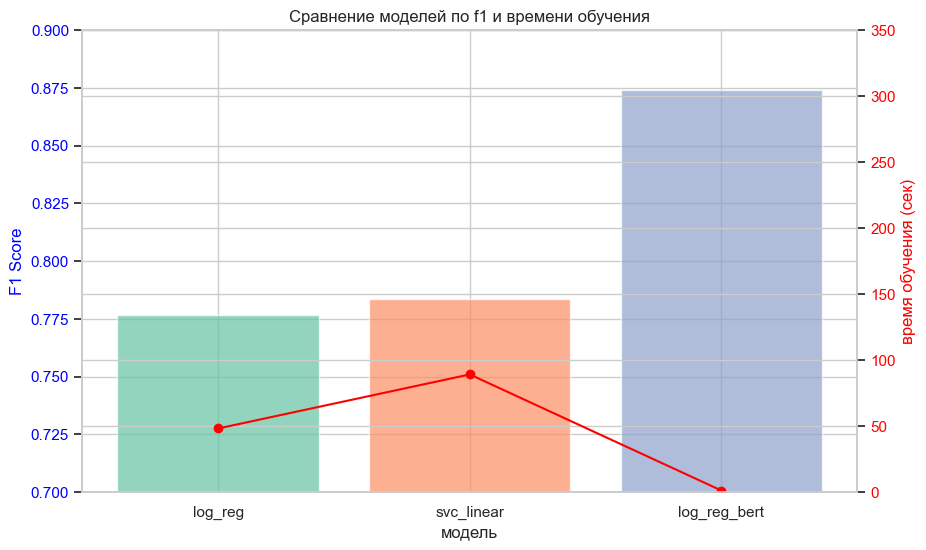

In [27]:
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))
colors = sns.color_palette("Set2")

# График F1-метрик (столбцы)
ax1.bar(compare['model'], compare['f1_cv'], color=colors, alpha=0.7, label='F1 метрика')
ax1.set_xlabel('модель')
ax1.set_ylabel('F1 Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0.7, 0.9)

# Создаем вторую ось для времени обучения
ax2 = ax1.twinx()
ax2.plot(compare['model'], compare['mean_fit_time_sec'], color='red', marker='o')
ax2.set_ylabel('время обучения (сек)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 350)

plt.title('Сравнение моделей по f1 и времени обучения')
plt.show()

**Теперь лучшая  модель это логистическая регрессия обученная на векторизированном через BERT тексте. C = 5**

In [29]:
y_pred_test = grid_search_bert.predict(X_test)

print('f1 лучшей модели на тестовой выборке: ', \
      round(f1_score(y_test, y_pred_test, average='binary', pos_label = 1), 4))


f1 лучшей модели на тестовой выборке:  0.9066


нужная метрика достигнута! Благодаря BERT ее удалось существенно повысить!

## Выводы

Задачей проекта была модель классифицирующая твиты как токсичные и нетоксичные. Согласно техническому заданию от модели требовалось значение метрики f1 не ниже 0.75. На этапе подготовки данных, проводилась лемматизация методом spacy и векторизация твитов методом tf-idf и BERT. На этапе обучения были испробованы две модели машинного обучения: LogisticRegression и LinearSVC. Для первых двух моделей на кроссвалидации подбирались параметры регуляризации и class_weight. Также у каждой модели подбирался параметр tf-idf n_gramm_range. Также эти две модели были испробованы при векторизации текста через BERT. По результатам сравнительного анализа моделей в качестве лучшей была выюрана логистическая регрессия с текстом векторизироанным через BERT, class_weight = balanced, C = 5, поскольку она обладает наилучшей точностью и скоростью обучения. Однако представление текстов через BERT занимает довольно много времени. На тестовой выборке модель показала себя хорошо, выполнив норматив по метрике f1 (0.9066)